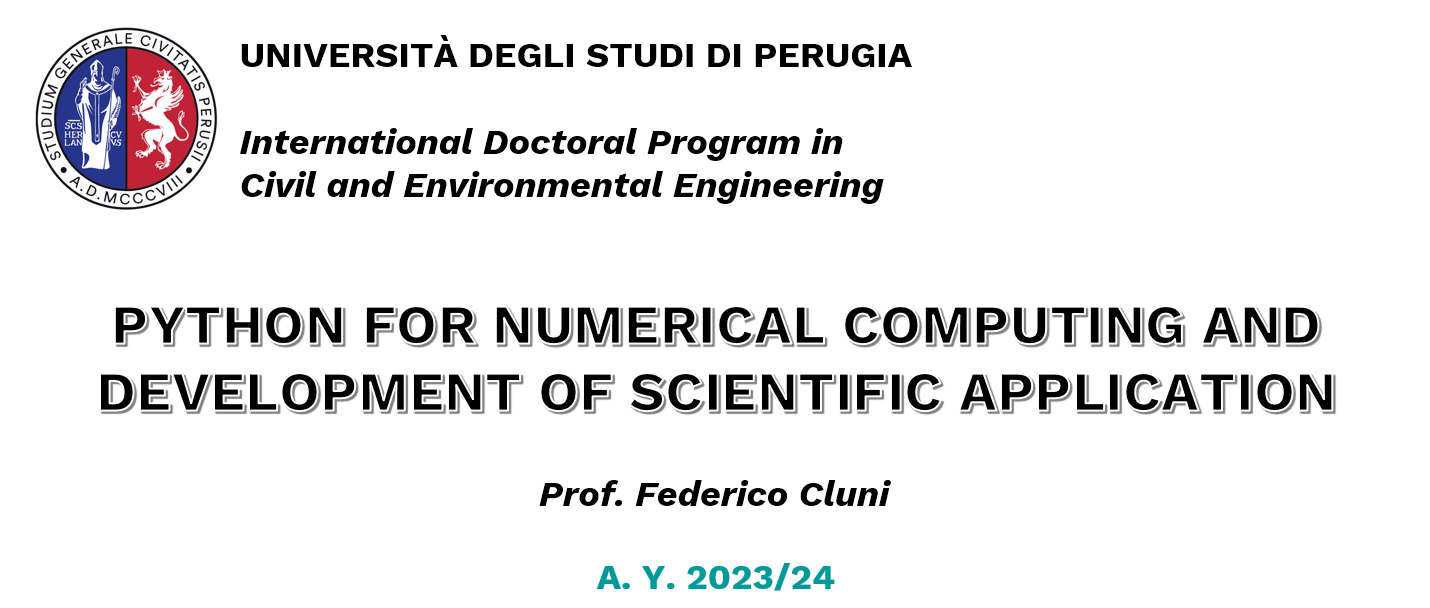

# Lesson #7 - April 5th, 2024
<hr>

The examples are adapted from:

R. Johansson, "Numerical Python: Scientific Computing and Data Science Applications With Numpy, Scipy and Matplotlib", Apress, 2018

In [1]:
import numpy as np
import numpy.linalg
import numpy.random as rd
import scipy
from scipy import integrate, stats
from sklearn import datasets, model_selection, linear_model, metrics, cluster
import matplotlib
import matplotlib.pyplot as plt

# Solving ODEs

We want to solve an ordinary differential equation, ODE.
Ordinary means that we have only one independent variable, say $x$.
The standard *explicit* form with only a function unkwown $y = y(x)$ is

$$ \frac{d^ny}{dx^n} = f\left( x, y, \frac{dy}{dx}, \ldots, \frac{d^{n-1}y}{dx^{n-1}} \right)$$

The initial condition (the values of $y$, $\frac{dy}{dx}$, $\ldots$, $\frac{d^{n-1}y}{dx^{n-1}}$ at $x=0$) are known, which are named **initial** value conditions.

An example with a first-order ODE is the following

$$ y'(x) = f(x, y) = x + y(x)^2$$

with initial condition

$$ y(0) = 0 $$

for 
$$x \in [0, 1.9] $$

In [2]:
def f(y, x):
    return x + y**2

Note that while the function $f$ is in closed form, a *sample* of $y$ at different values of $x$, $x_k$, is returned.

We use the method `odeint` of module `integrate` (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)), which implement the LSODA method.

In [3]:
y0 = 0.
xp = np.linspace(0,1.9,100)
yp = integrate.odeint(f, y0, xp)

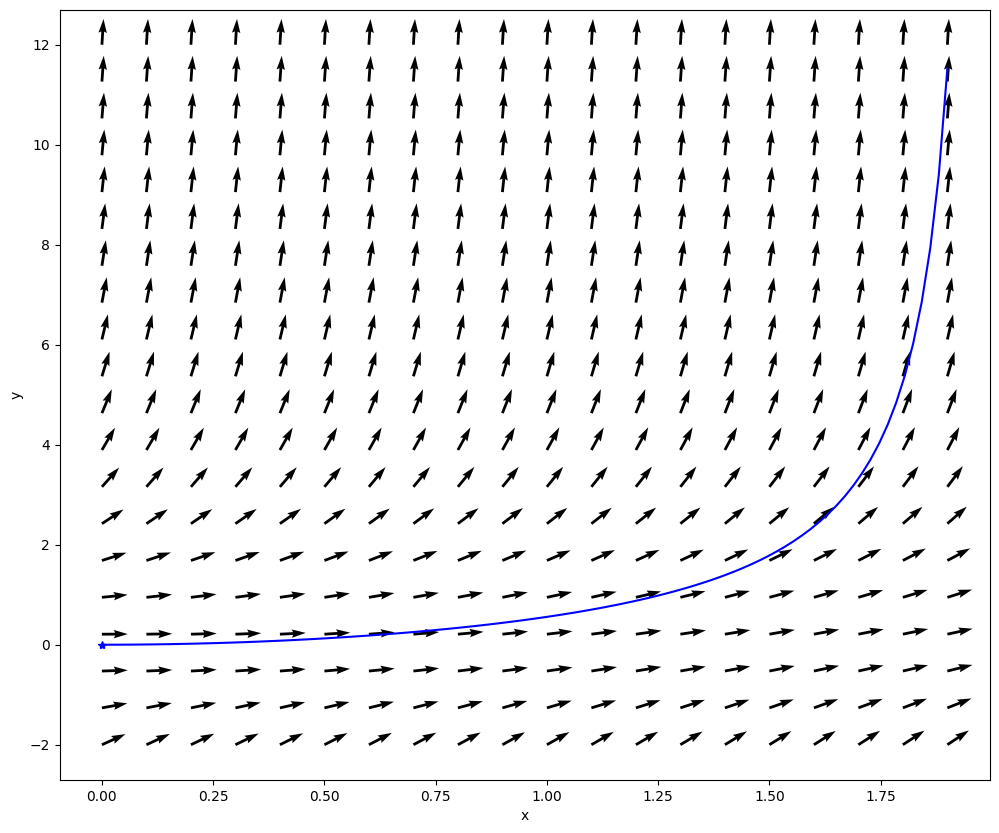

In [4]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(xp, yp, 'b-')

X, Y = np.meshgrid(np.linspace(0,1.9,20),np.linspace(-2,12,20))
yprime = np.array([f(y_, x_) for (x_, y_) in zip(X,Y)])

ax.set_xlabel('x')
ax.set_ylabel('y')
alfa = np.arctan(yprime)
ax.quiver(X,Y,np.cos(alfa)*.1, np.sin(alfa)*.1, angles='xy')
ax.plot(0,0,'b*')
ax.grid(False)

Note that $y'$ gives the slope of the tangent, and therefore in the figure above the solution is always tangent to the arrow field with components $\left( \cos\left(\tan^{-1}f(x,y)\right), \sin\left(\tan^{-1}f(x,y)\right) \right)$, which is called *direction field*.

An example of a system with two ordinary differential equations is the Lotka-Volterra predator and prey model.
Given

$$x(t) = \left[ \begin{array}{r} x_0(t) \\ x_1(t) \end{array} \right], x'(t) = \left[ \begin{array}{r} x'_0(t) \\ x'_1(t) \end{array} \right]$$

we have

$$ x'(t) = f(t,x) = \left\{ \begin{array}{l}  ax_0(t) - bx_0(t)x_1(t) \\ cx_0(t)x_1(t) - dx_1(t) \end{array} \right.$$

Where $x_0$ is the number of prey and $x_1$ is the number of predators, $t$ is the independent variable time (which is **not** directly involved in the definition of $f$!).
$a, b, c, d$ are the parameters of the model.

In [5]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7
def f(x, t):
    return [a*x[0]-b*x[0]*x[1],c*x[0]*x[1]-d*x[1]]

As an example, suppose that at $t=0$ there are 600 preys and 400 predators.

In [6]:
x0 = [600, 400]
t = np.linspace(0, 50, 250)
x = integrate.odeint(f, x0, t)

Note that the results is an array where the first dimension is the time and the second dimension the sample of the solution ($x_0$ and $x_1$).

In [7]:
x.shape

(250, 2)

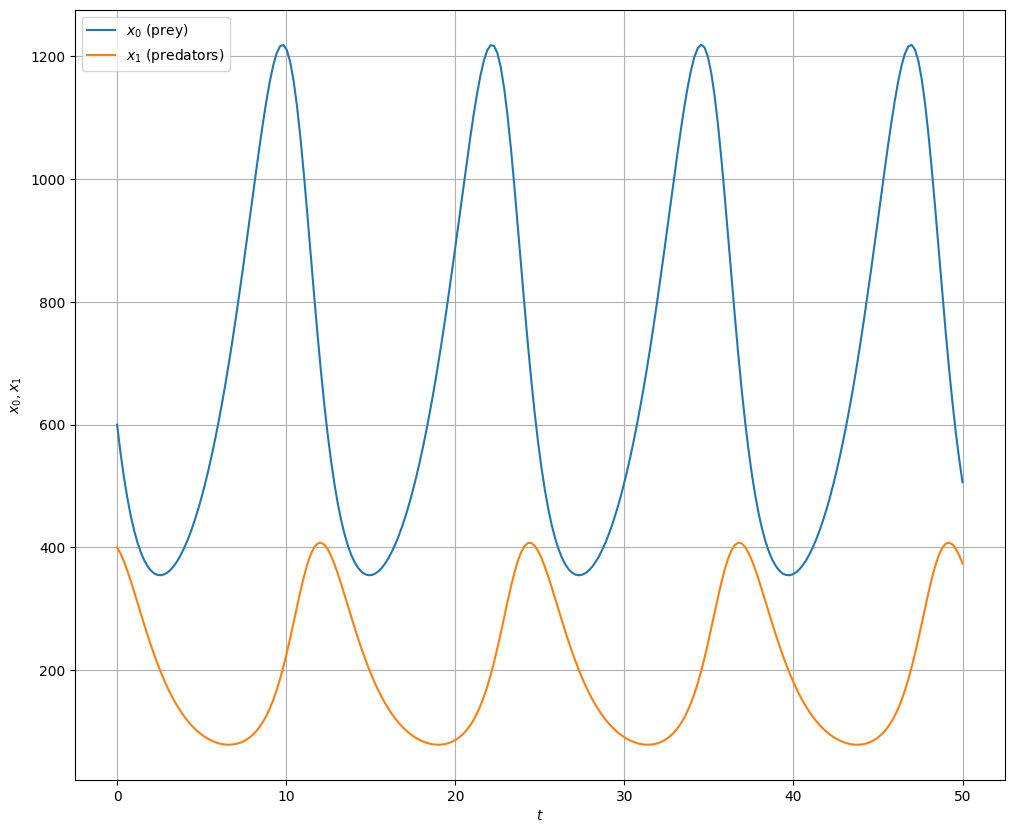

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(t, x[:,0], label='$x_0$ (prey)')
ax.plot(t, x[:,1], label='$x_1$ (predators)')
ax.set_xlabel('$t$')
ax.set_ylabel('$x_0, x_1$')
ax.legend()
ax.grid(True)

Also in this case is possible to plot the direction field, this time anyway $f$ gives directly the components of the arrows.

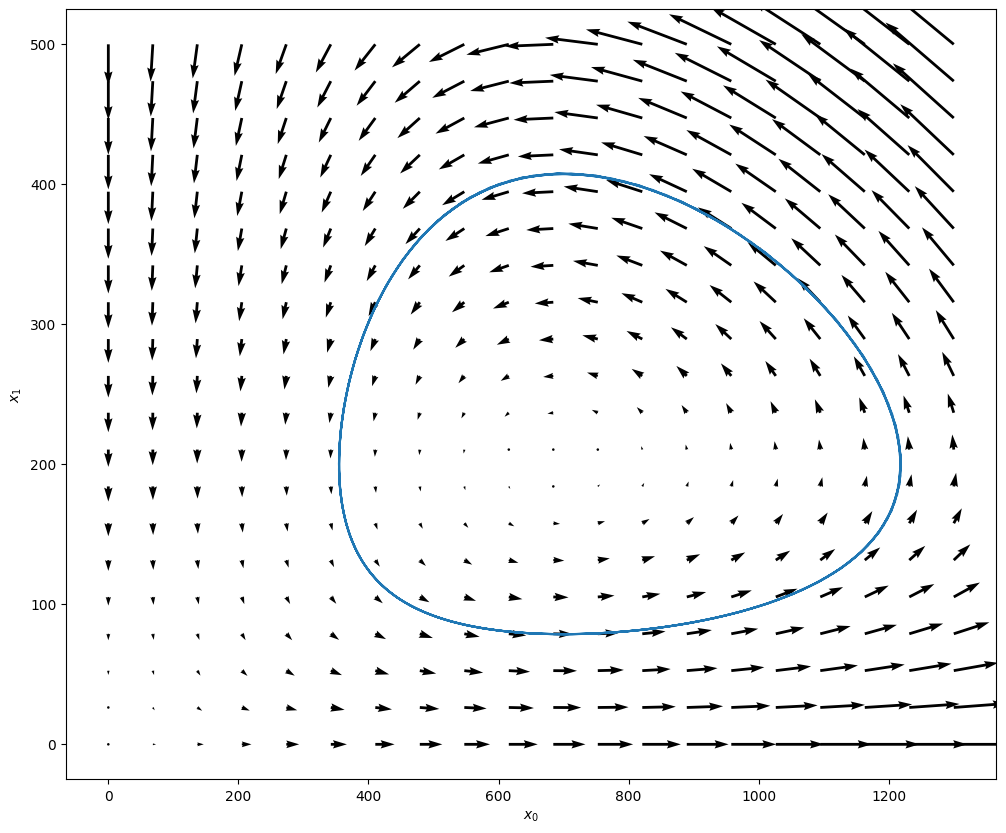

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(x[:,0],x[:,1])

X, Y = np.meshgrid(np.linspace(0,1300,20),np.linspace(0,500,20))
Z = f(np.vstack([X.ravel(),Y.ravel()]),0)

ax.quiver(X,Y,Z[0],Z[1], angles='xy')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.grid(False)

The presence of a closed loop means that it is a stable (periodic) solution.

In the case we have a system of ODE of higher order, we can transform it anyway to a system of first order ODES.

For example, in the case of two masses, $m_0$ and $m_1$, connected by springs with stiffness $k_0$ and $k_1$ and dampers with $c_0$ and $c_1$ in free vibration

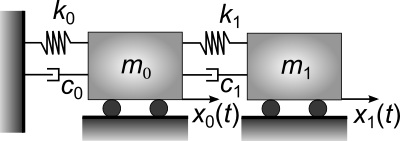

$$ \left\{ \begin{array}{l} m_0 x_0''(t) +c_0 x_0' + k_0 x_0 - k_1 (x_1-x_0) = 0 \\
m_1 x_1''(t) -c_1 x_1' + k_1 (x_1-x_0) = 0 \end{array}\right.$$

Defining

$y_0 = x_0$, $y_1 = x_0'$, $y_2 = x_1$, $y_3 = x_1'$

we have

$$ \left\{ \begin{array}{l} y_0' = y_1 \\
m_0 y_1' +c_0 y_1 + k_0 y_0 - k_1 (y_2-y_0) = 0 \\
y_2' = y_3 \\
m_1 y_3' -c_1 y_3 + k_1 (y_2-y_0) = 0 \end{array} \right.$$

and finally

$$ \left\{ \begin{array}{l} y_0' = y_1\\
y_1' = -\frac{1}{m_0}\left(c_0 y_1 + k_0 y_0 - k_1 (y_2-y_0) \right)\\
y_2' = y_3\\
y_3' = -\frac{1}{m_1}\left( -c_1 y_3 + k_1 (y_2-y_0) \right)\end{array} \right.$$

In this case we use the general interface to the integrators for ODE, `ode`, and therefore the function $f$ is defined in slighly different way (the independent variable is the **first** argument).

In [10]:
def f(t, y, args):
    m0, k0, c0, m1, k1, c1 = args
    return [y[1], -1/m0*(c0*y[1]+k0*y[0]-k1*(y[2]-y[0])), y[3], -1/m1*(-c1*y[3] + k1*(y[2]-y[0]))]

In [11]:
m0, k0, c0 = 1.0, 10., 0.5
m1, k1, c1 = 2.0, 40., 0.25
args = (m0, k0, c0, m1, k1, c1)
y0 = [1.0, 0., 0.5, 0]
t = np.linspace(0,20,1000)

In [12]:
r = integrate.ode(f)

We use the same method seen before, LSODA.

In [13]:
r.set_integrator('lsoda')
r.set_initial_value(y0, t[0])
r.set_f_params(args)

In [14]:
dt = t[1] -t[0]
y = np.zeros((len(t),len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx,:] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [15]:
y

array([[ 1.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.99402078, -0.59507831,  0.50200028,  0.19938373],
       [ 0.97631331, -1.16921418,  0.50794404,  0.39291021],
       ...,
       [-0.36507105, -0.08643303, -0.45415847, -0.1066892 ],
       [-0.3667749 , -0.08373832, -0.45593938, -0.07120383],
       [-0.36842058, -0.08053695, -0.45700954, -0.03572977]])

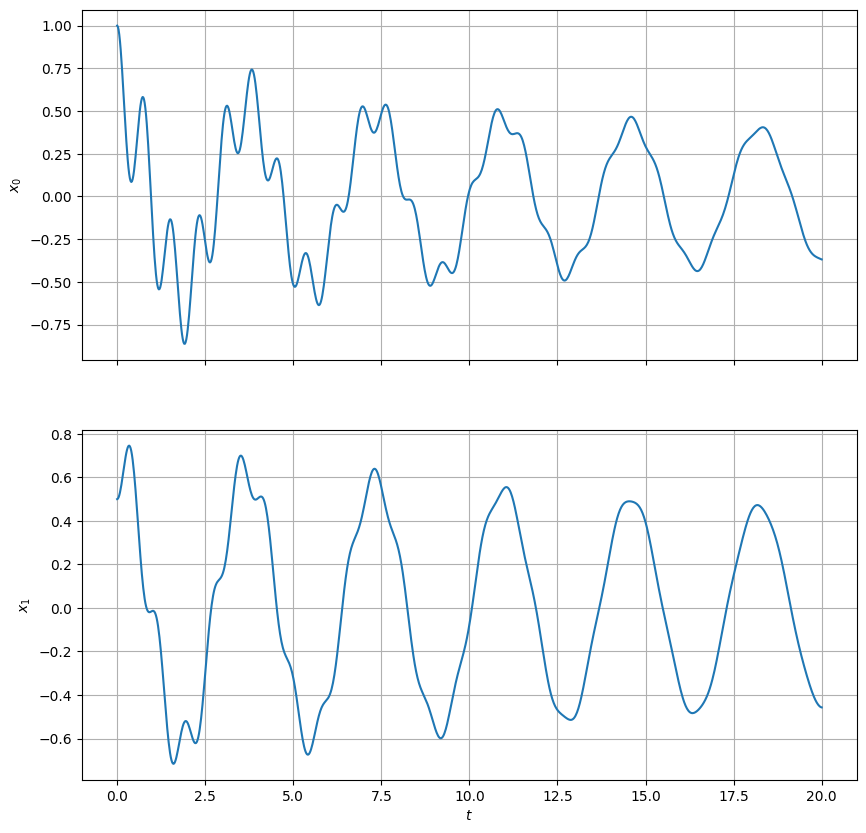

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.plot(t,y[:,0])
ax1.set_ylabel('$x_0$')
ax1.set_xticklabels([])
ax1.grid(True)
ax2.plot(t,y[:,2])
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x_1$')
ax2.grid(True)

---

# Probability and statistics

We have seen that it is possible to generate pseudo-random numbers.
To generate a random number from a uniform distribution (it meens that every number between 0 (included) and 1 (excluded) has equal probability of being drawn)

In [17]:
np.random.rand()

0.7614144481988988

We can generate arrays with any number of dimensions

In [18]:
x = np.random.rand(11)
x

array([0.45856853, 0.89424395, 0.54181569, 0.1922975 , 0.74615842,
       0.33437025, 0.01132101, 0.90356094, 0.58047799, 0.30047987,
       0.29446167])

In [19]:
X = np.random.rand(4,3,2)
X

array([[[0.83658388, 0.34352407],
        [0.43970965, 0.05114995],
        [0.61861958, 0.50884053]],

       [[0.06486519, 0.1405194 ],
        [0.96392374, 0.27521781],
        [0.13470454, 0.890018  ]],

       [[0.5107955 , 0.52395443],
        [0.39363654, 0.63409034],
        [0.30680214, 0.79597579]],

       [[0.46845622, 0.42845971],
        [0.85307311, 0.85394156],
        [0.43369782, 0.20312093]]])

The usual statistical quantities can be evaluated, mean

In [20]:
np.mean(x)

0.4779778016954785

median

In [21]:
np.median(x)

0.45856853114092544

In [22]:
np.sort(x)

array([0.01132101, 0.1922975 , 0.29446167, 0.30047987, 0.33437025,
       0.45856853, 0.54181569, 0.58047799, 0.74615842, 0.89424395,
       0.90356094])

Please not that

In [23]:
np.sort(x)[int(len(x)/2)-1]

0.3343702487892144

the variance

In [24]:
x.var()

0.0751332957881818

In [25]:
1/(len(x))*np.sum((x-x.mean())**2)

0.0751332957881818

If we are interested in the _sample_ variance

In [26]:
x.var(ddof=1)

0.08264662536699999

In [27]:
1/(len(x)-1)*np.sum((x-x.mean())**2)

0.08264662536699999

In [28]:
x.std() # or x.std(ddof=1) 

0.27410453441740396

It is also possible to generate numbers distributed according to the standard normal distribution(mean $\mu=0$ and standard deviation $\sigma=1$).

In [29]:
np.random.randn()

-0.01886100861817829

We can also generate _discrete_ values from a uniform distbution

In [30]:
np.random.randint(0,10)

1

In order to visualize the obtained numbers, an histogram is often useful

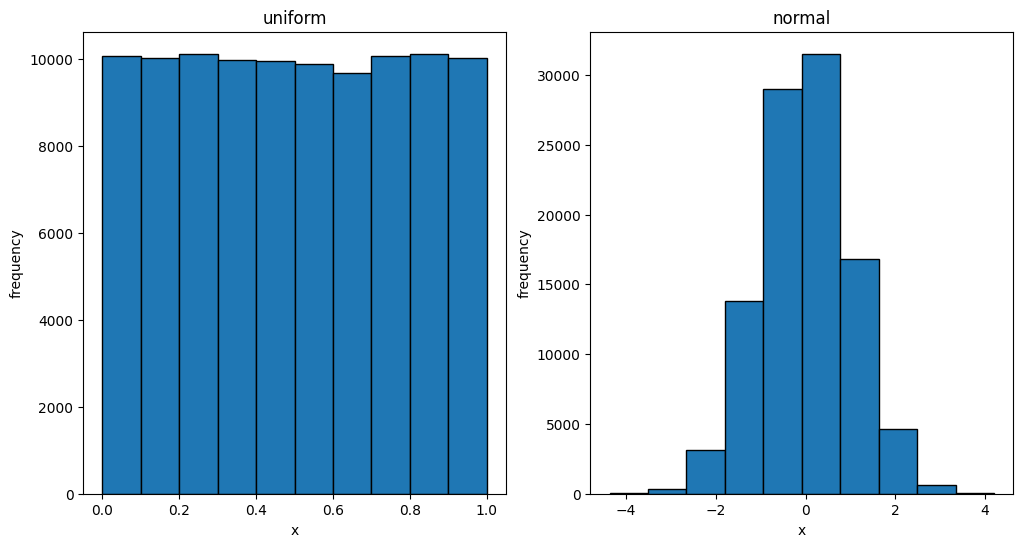

In [31]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(np.random.rand(100000),edgecolor='k')
ax[0].set(xlabel="x", ylabel="frequency", title="uniform")
ax[1].hist(np.random.randn(100000),edgecolor='k')
ax[1].set(xlabel="x", ylabel="frequency", title="normal")
plt.show() # only to suppress visualization of last command

In [32]:
ax[0].hist(np.random.rand(100000),edgecolor='k')

(array([10119.,  9902., 10112.,  9939.,  9910., 10081., 10125.,  9998.,
         9951.,  9863.]),
 array([3.79879715e-06, 1.00003359e-01, 2.00002919e-01, 3.00002479e-01,
        4.00002039e-01, 5.00001599e-01, 6.00001159e-01, 7.00000719e-01,
        8.00000280e-01, 8.99999840e-01, 9.99999400e-01]),
 <BarContainer object of 10 artists>)

Please note that `hist` return a tuple where the first element is the array of frequencies and the second element is an array with the edges of the bins.

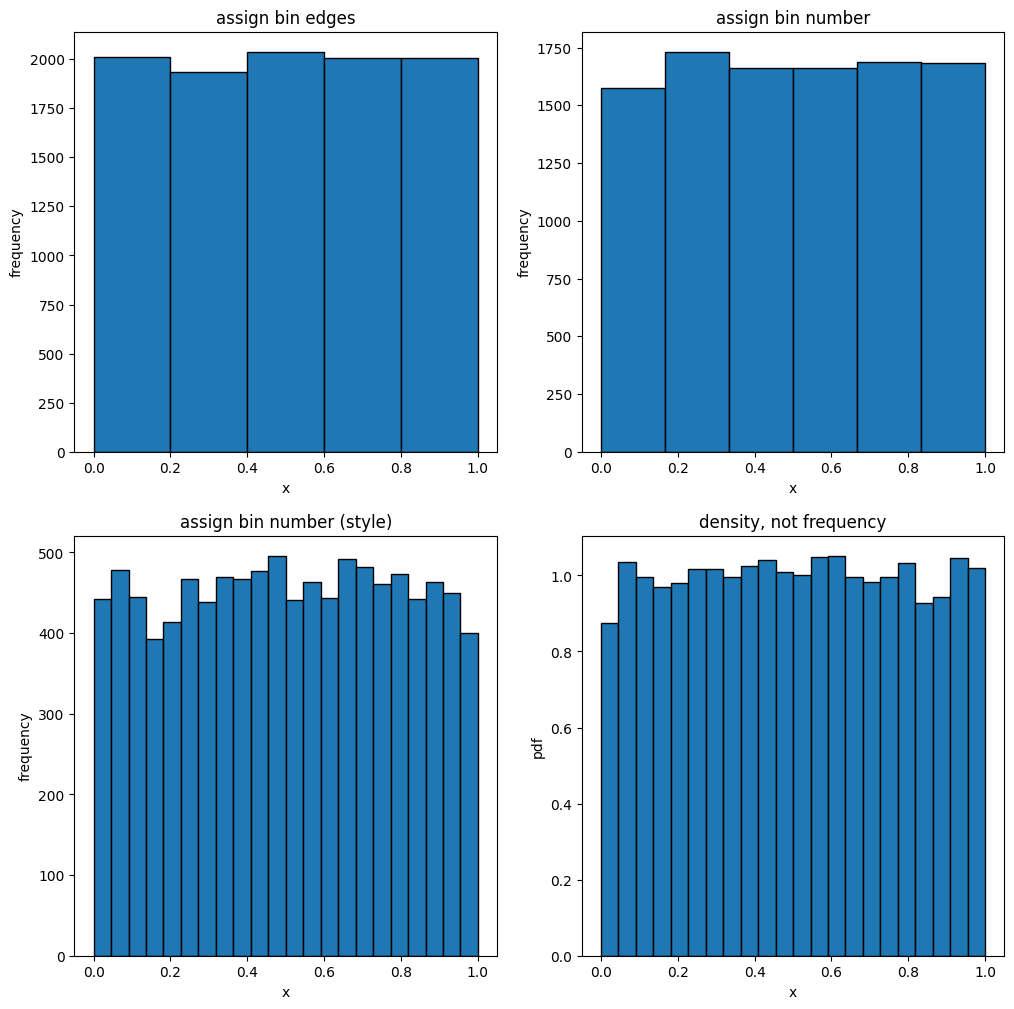

In [33]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].hist(np.random.rand(10000),bins=[0,0.2,0.4,0.6,0.8,1],edgecolor='k')
ax[0,0].set(xlabel="x", ylabel="frequency", title="assign bin edges")
ax[0,1].hist(np.random.rand(10000),bins=6,edgecolor='k')
ax[0,1].set(xlabel="x", ylabel="frequency", title="assign bin number")
ax[1,0].hist(np.random.rand(10000),bins='scott',edgecolor='k') # see https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
ax[1,0].set(xlabel="x", ylabel="frequency", title="assign bin number (style)") 
ax[1,1].hist(np.random.rand(10000),bins='scott',density=True,edgecolor='k')
ax[1,1].set(xlabel="x", ylabel="pdf", title="density, not frequency")
plt.show()

Since the numbers are *pseudo*-random, it is possible to generate the same sequence

In [34]:
np.random.seed(1234)
np.random.rand(3)

array([0.19151945, 0.62210877, 0.43772774])

In [35]:
np.random.rand(3)

array([0.78535858, 0.77997581, 0.27259261])

In [36]:
np.random.seed(1234)
np.random.rand(3)

array([0.19151945, 0.62210877, 0.43772774])

## Distributions

A more advanced way of working with random numbers is to use the package `stats` from Scipy.

We can generate an object wchich represents a normal distribution with mean $\mu=1$ and standard deviation $\sigma=0.5$.

In [37]:
X = stats.norm(loc=1, scale=0.5)

The interpretation of `loc` and `scale` depends on the distribution, here they are the mean and the standard deviation respectively.

The most common statistics are available...

In [38]:
X.mean(), X.median(), X.var(), X.std()

(1.0, 1.0, 0.25, 0.5)

... but we can evaluate every moment of the distribution.

In [39]:
[X.moment(n) for n in range(5)]

[1.0, 1.0, 1.25, 1.75, 2.6875]

The object has the following important methods:
- `pdf` for the probability density function
- `cdf` for the cumulative distribution function
- `sf` the survival function (1-`cdf`)
- `ppf` Percent-point function (inverse of `cdf`)

To get the limit of the interval within which the 95% of possible values are found

In [40]:
X.interval(0.95)

(0.020018007729972975, 1.979981992270027)

We can check that the probaibility that a value is below the precribed threshold is ideed

In [41]:
X.ppf(0.025), X.ppf(0.975)

(0.020018007729972753, 1.979981992270027)

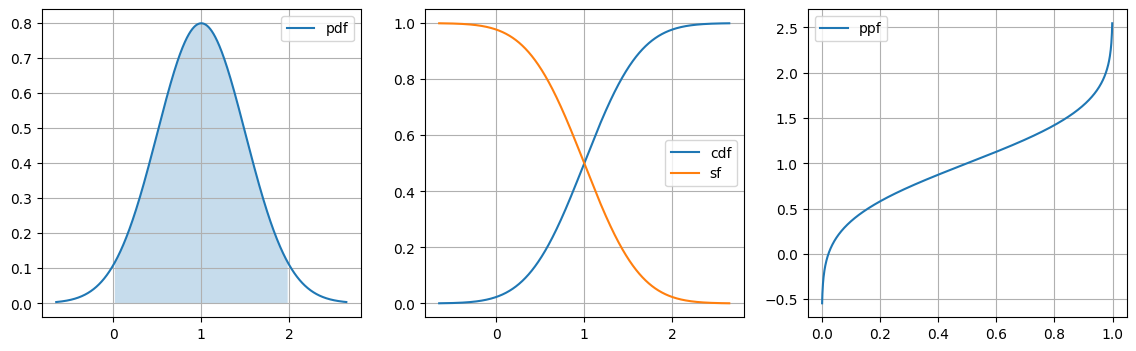

In [42]:
x999 = np.linspace(*X.interval(0.999),1000)
x95 = np.linspace(*X.interval(0.95),1000)

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(x999, X.pdf(x999), label='pdf')
ax[0].fill_between(x95, X.pdf(x95), alpha=0.25)
ax[1].plot(x999,X.cdf(x999), label='cdf')
ax[1].plot(x999,X.sf(x999), label='sf')
ax[2].plot(np.linspace(0,1,1000), X.ppf(np.linspace(0,1,1000)),label='ppf')
for n in range(3): 
    ax[n].legend()
    ax[n].grid(True)

To draw numbers according to the selected probability distribution, we use the method `rvs` which works like `rand`

In [43]:
X.rvs()

1.331254518726606

In [44]:
Xs = X.rvs(1000)

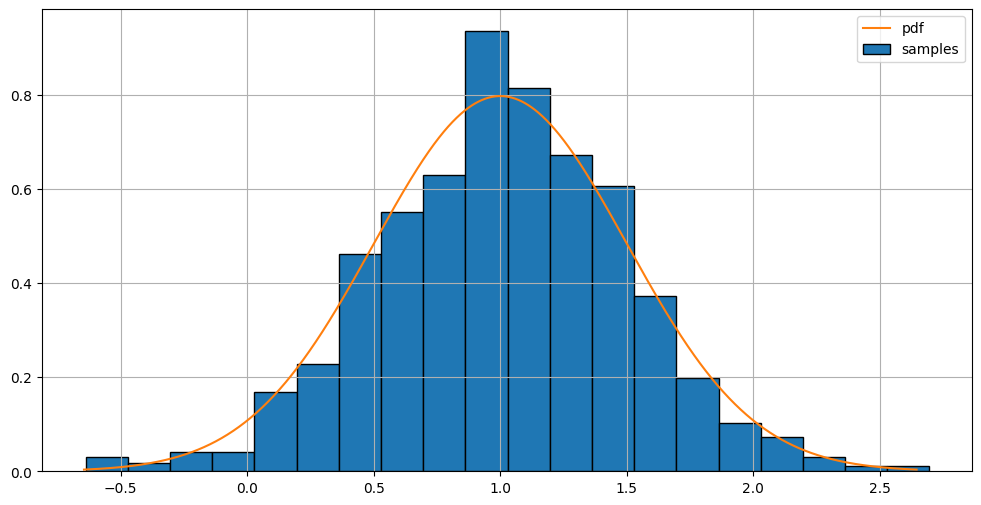

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(x999, X.pdf(x999), color='C1', label = 'pdf')
ax.hist(Xs, density=True, bins='scott', color='C0', edgecolor='k', label='samples')
ax.grid(True)
ax.legend()

Given a sample, it is also possible to fit the parameters of a distribution to the sample values.

In [46]:
loc, scale = stats.norm.fit(Xs)

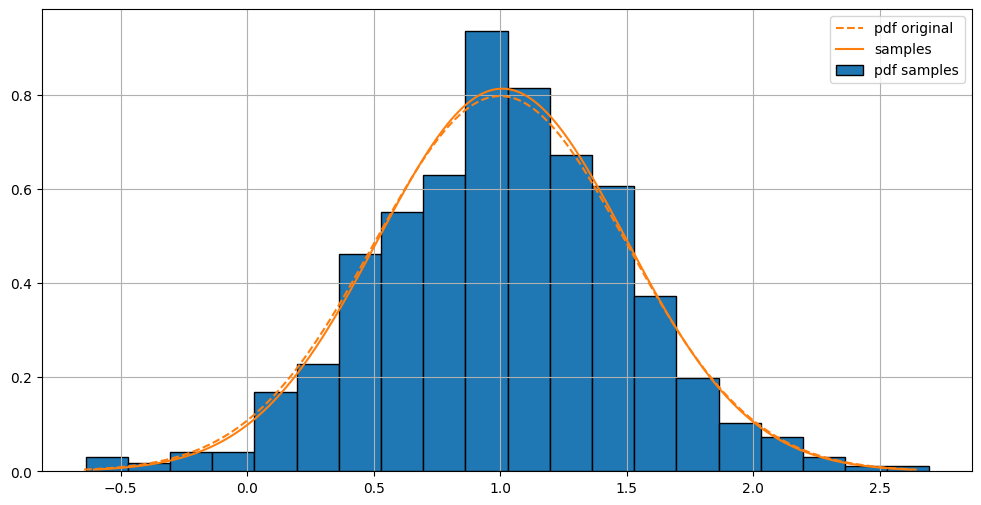

In [47]:
Xf = stats.norm(loc=loc, scale=scale)
x999f = np.linspace(*Xf.interval(0.999),1000)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(x999, X.pdf(x999), color='C1', linestyle='dashed', label ='pdf original')
ax.plot(x999f, Xf.pdf(x999f), color='C1', label='samples')
ax.hist(Xs, density=True, bins='scott', color='C0', edgecolor='k', label='pdf samples')
ax.grid(True)
ax.legend()

## Hypothesis Testing

As an example, we want to check if a random variable has mean $\mu_0=1$ having only a sample of that variable.

If we know tha population standard deviation (in this case equal to 0.5)

In [48]:
z = (Xs.mean()-1.0)/(0.5/np.sqrt(len(Xs)))

In [49]:
z

0.4722410512374964

In [50]:
stats.norm().interval(0.95)

(-1.959963984540054, 1.959963984540054)

The value of $z$ is within the 95% interval, so the null hypothesis can not be rejected.

In [51]:
Xs2 = stats.norm(loc=0.95, scale=0.5).rvs(len(Xs))

In [52]:
z2 = (Xs2.mean()-1.0)/(0.5/np.sqrt(len(Xs2)))
z2

-2.4371077646962864

In this case, the value of $z$ is outside the 95% interval, so the null hypothesis can be rejected.

This if corfimed by the fact that the probaiblity of having a mean less or equal than $z$ is very small.

In [53]:
stats.norm().cdf(z2)

0.007402633207541963

A way to compare if a sample is from a prescribed distribution is to use the method `kstest`.

---

# Machine learning

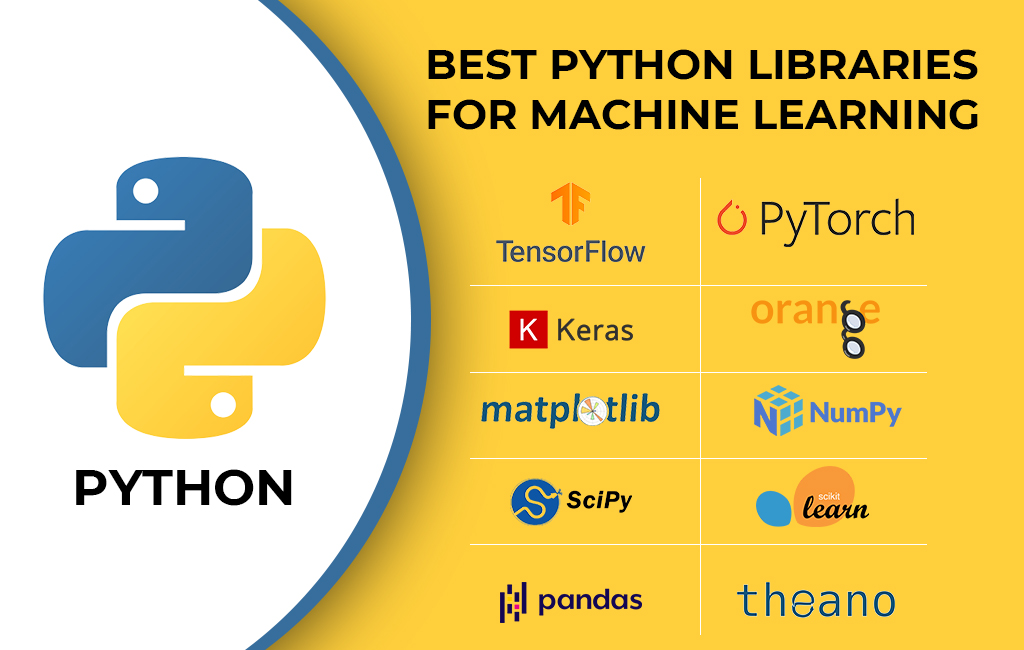

Source of image: [https://devopedia.org/machine-learning-in-python](https://devopedia.org/machine-learning-in-python)

Machine learning comprises all applications where feeding training data into a computer makes it able to perform a given task (Johanson).

With _training_ the observed data are used to fit a model to them.

The application can be _supervised_ or _unsupervised_: in supervised applications, we know the _feature variables_ and the _response variables_, in unsupervised application the data are not manually prepared or labeled.

The topic is vast, we'll just look at some (simple) examples.

## Regression

This is similar to what we saaw in Lecture 6.

In [54]:
X_all, y_all = datasets.make_regression(n_samples=50, n_features=50, n_informative=10)

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, train_size=0.5)

In [56]:
model = linear_model.LinearRegression()

In [57]:
model.fit(X_train, y_train)

LinearRegression()

The method `predict` can be used to evaluate response given features.

Text(0.5, 1.0, 'Coefficients')

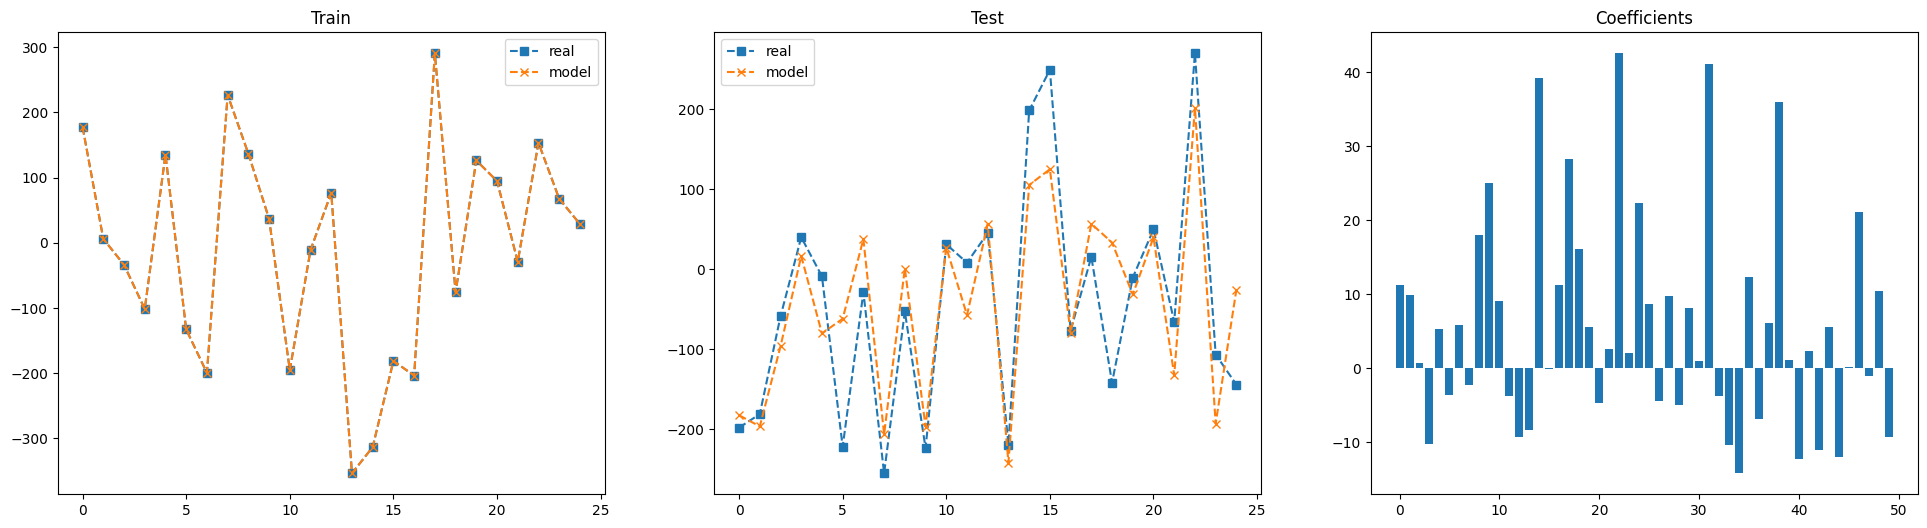

In [58]:
fig, ax = plt.subplots(1,3,figsize=(24,6))
ax[0].plot(y_train,'s--', label='real')
ax[0].plot(model.predict(X_train),'x--', label = 'model')
ax[0].legend()
ax[0].set_title('Train')
ax[1].plot(y_test,'s--', label='real')
ax[1].plot(model.predict(X_test),'x--', label = 'model')
ax[1].legend()
ax[1].set_title('Test')
ax[2].bar(np.arange(len(model.coef_)),model.coef_)
ax[2].set_title('Coefficients')

In [59]:
def sse(resid):
    return np.sum(resid**2)

In [60]:
resid_train = y_train - model.predict(X_train)
sse_train=sse(resid_train)
sse_train

4.811704423049875e-25

In [61]:
resid_test = y_train - model.predict(X_test)
sse_test=sse(resid_test)
sse_test

1082862.0454552486

### Regularized regression

In [62]:
model = linear_model.Ridge(alpha=2.5)

In [63]:
model.fit(X_train, y_train)

Ridge(alpha=2.5)

Text(0.5, 1.0, 'Coefficients')

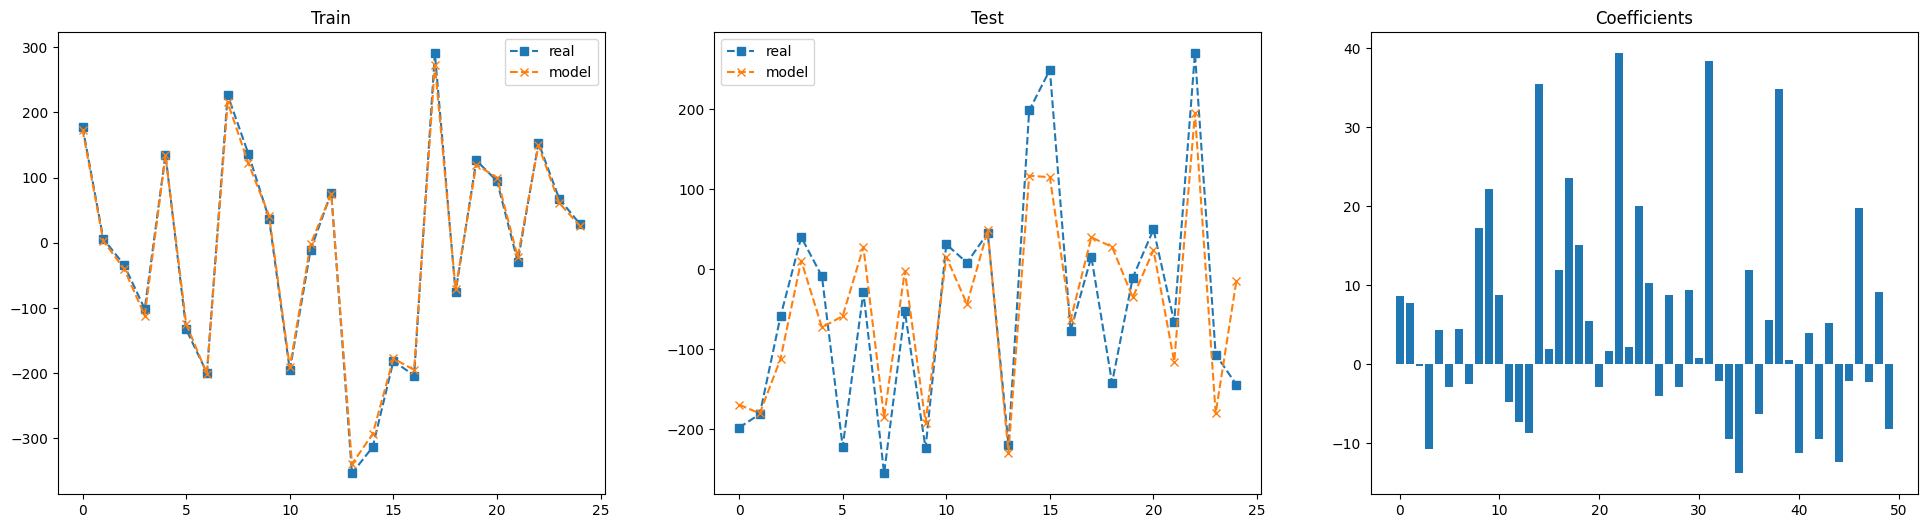

In [64]:
fig, ax = plt.subplots(1,3,figsize=(24,6))
ax[0].plot(y_train,'s--', label='real')
ax[0].plot(model.predict(X_train),'x--', label = 'model')
ax[0].legend()
ax[0].set_title('Train')
ax[1].plot(y_test,'s--', label='real')
ax[1].plot(model.predict(X_test),'x--', label = 'model')
ax[1].legend()
ax[1].set_title('Test')
ax[2].bar(np.arange(len(model.coef_)),model.coef_)
ax[2].set_title('Coefficients')

In [65]:
resid_train = y_train - model.predict(X_train)
sse_train=sse(resid_train)
sse_train

1919.9774963291443

In [66]:
resid_test = y_train - model.predict(X_test)
sse_test=sse(resid_test)
sse_test

1045497.9329332208

In [67]:
model = linear_model.Lasso(alpha=1)

In [68]:
model.fit(X_train, y_train)

Lasso(alpha=1)

Text(0.5, 1.0, 'Coefficients')

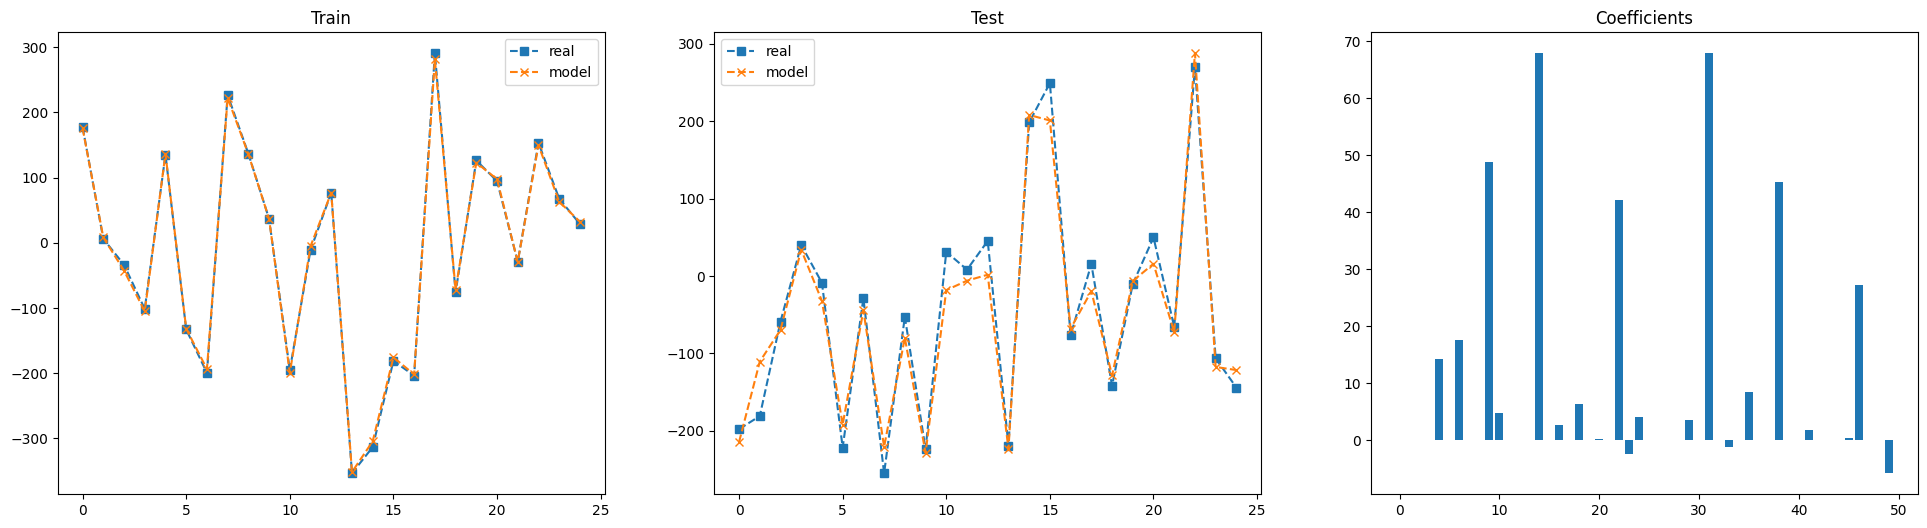

In [69]:
fig, ax = plt.subplots(1,3,figsize=(24,6))
ax[0].plot(y_train,'s--', label='real')
ax[0].plot(model.predict(X_train),'x--', label = 'model')
ax[0].legend()
ax[0].set_title('Train')
ax[1].plot(y_test,'s--', label='real')
ax[1].plot(model.predict(X_test),'x--', label = 'model')
ax[1].legend()
ax[1].set_title('Test')
ax[2].bar(np.arange(len(model.coef_)),model.coef_)
ax[2].set_title('Coefficients')

In [70]:
resid_train = y_train - model.predict(X_train)
sse_train=sse(resid_train)
sse_train

496.40416905161703

In [71]:
resid_test = y_train - model.predict(X_test)
sse_test=sse(resid_test)
sse_test

1249092.232078213

## Classification

Depending on the feature variable, the application associate a category.

In [72]:
iris = datasets.load_iris()

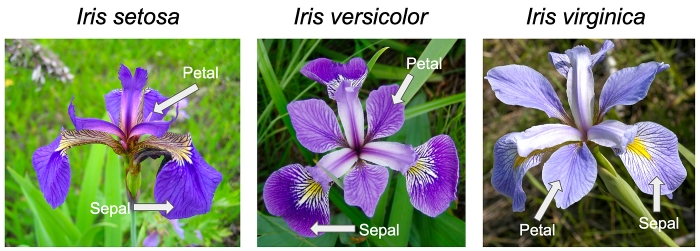

Source for the image: [https://towardsdatascience.com/the-iris-dataset-a-little-bit-of-history-and-biology-fb4812f5a7b5](https://towardsdatascience.com/the-iris-dataset-a-little-bit-of-history-and-biology-fb4812f5a7b5)

In [73]:
iris.target_names, iris.feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [74]:
iris.data.shape

(150, 4)

In [75]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(iris.data, iris.target, train_size=0.7)

In [76]:
classifier = linear_model.LogisticRegression()

In [77]:
classifier.fit(X_train, y_train)

LogisticRegression()

In [78]:
y_test_pred = classifier.predict(X_test)

In [79]:
y_test_pred

array([0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0,
       1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1,
       2])

In [80]:
y_test

array([0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0,
       1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 1,
       2])

In [81]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[16,  0,  0],
       [ 0, 13,  1],
       [ 0,  2, 13]], dtype=int64)

Two elements 'virginica' (class 2) were incorrectly classified as 'versicolor' (class 1)

In [82]:
y_test

array([0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0,
       1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 1,
       2])

In [83]:
y_test_pred

array([0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0,
       1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1,
       2])

## Clustering

The applications seeks to classify the items but without knowing in advance the classes (it is an example of unsupervised learning).

In [84]:
X, y = iris.data, iris.target

In [85]:
n_clusters = 3
clustering = cluster.KMeans(n_clusters=n_clusters)

In [86]:
clustering.fit(X)

KMeans(n_clusters=3)

In [87]:
y_pred = clustering.predict(X)

Note the numeration of classes is arbitrary!

In [88]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [89]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [90]:
y_pred[::8]

array([2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [91]:
y[::8]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [92]:
idx_0, idx_1, idx_2 = (np.where(y_pred==n) for n in range(3))

In [93]:
y_pred[idx_0], y_pred[idx_1], y_pred[idx_2] = 1, 0, 2
y_pred[::8]

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [94]:
metrics.confusion_matrix(y, y_pred)

array([[ 0,  0, 50],
       [48,  2,  0],
       [14, 36,  0]], dtype=int64)

In [95]:
X.shape[1]

4

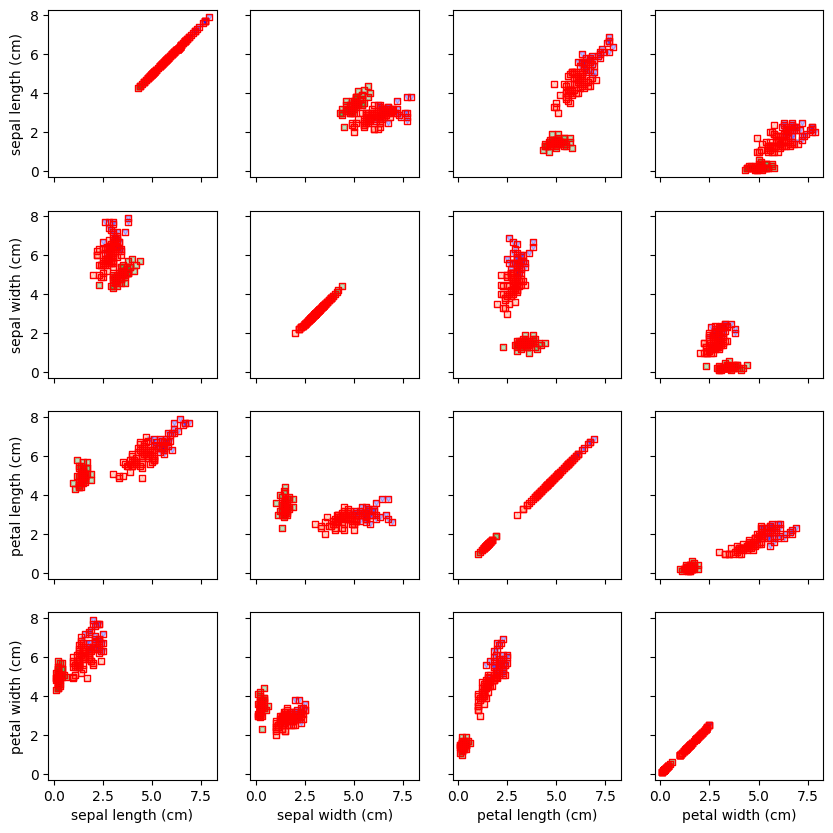

In [96]:
N = X.shape[1]
fig, axes = plt.subplots(N, N, figsize=(10, 10), sharex=True, sharey=True)
colors = ["coral", "blue", "green"]
markers = ["^", "v", "o"]
for m in range(N):
	for n in range(N):
		for p in range(n_clusters):
			mask = y_pred == p
			axes[m, n].scatter(X[:, m][mask], X[:, n][mask], s=15, marker=markers[p], color=colors[p], alpha=0.25)
		for idx in np.where(y != y_pred):
			axes[m, n].scatter(X[idx, m], X[idx, n], s=15, marker="s", edgecolor="red", facecolor=(1,1,1,0))
	axes[N-1, m].set_xlabel(iris.feature_names[m])
	axes[m, 0].set_ylabel(iris.feature_names[m])